### Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
from scipy.stats import truncnorm
from matplotlib.colors import LogNorm
from scipy.stats import multivariate_normal
from scipy.stats import norm
from ROOT import TFile, TTree

# Add the parent directory of simpleparameterisation to the sys.path list
sys.path.append('../')

# Now you can import simpleparameterisation from the new location
import TPCevt as TPC
det = TPC.Detector("Simple TPC with Atmospheric Ar (default values)")


Welcome to JupyROOT 6.28/00


In [2]:
def driftsigma_trans(z, det):
    return np.sqrt(2*z*det.D_xy/det.vdrift)

def driftsigma_long(z, det):
    return np.sqrt(2*z*det.D_z/det.vdrift)


def getData(f, saveevt):
    # Get Center Coordinate
    z0_values = np.asarray([evt.z0 for evt in f.data])
    max_z = np.max(z0_values)
    min_z = np.min(z0_values)  
    center_z = (max_z - min_z)/2

    for i, evt in enumerate(f.data):
        if i == saveevt:
            x = np.asarray(evt.x) / 10 + center_z / 10
            y = np.asarray(evt.y) / 10 + center_z / 10
            z = np.asarray(evt.z) / 10 + center_z / 10
            Edep = np.asarray(evt.edep) * 1000
            PrimaryEvt = np.stack((x, y, z, Edep))
            break
    return PrimaryEvt

def generateCarriers(PrimaryEvt, det):
    nip_list = np.random.poisson(PrimaryEvt[3]/det.wval)
    return np.append(PrimaryEvt, [nip_list], axis=0)


def driftCarriers(PrimaryEvtNIP, det):
    NIP = PrimaryEvtNIP[4].astype(int)
    z_list = PrimaryEvtNIP[2].repeat(NIP)
    DriftedEvt = np.array([
        np.arange(len(NIP)).repeat(NIP),
        PrimaryEvtNIP[0].repeat(NIP) + np.random.normal(loc=0, scale=driftsigma_trans(z_list, det )),
        PrimaryEvtNIP[1].repeat(NIP) + np.random.normal(loc=0, scale=driftsigma_trans(z_list, det )),
        (PrimaryEvtNIP[2].repeat(NIP) + np.random.normal(loc=0, scale=driftsigma_trans(z_list, det )))/det.vdrift,
    ])
    return DriftedEvt


def printPrimary(PrimaryEvt):
    print(' x        y        z       Edep   ')
    for i in range(len(PrimaryEvt[0])):
        x = PrimaryEvt[0][i]
        y = PrimaryEvt[1][i]
        dt = PrimaryEvt[2][i]
        Edep = PrimaryEvt[3][i]
        print(f' {x:.4f}  {y:.4f}  {dt:.4f}  {Edep:.4f}')

def printPrimaryNIP(PrimaryEvtNIP):
    print(' x       y        z        Edep    NIP')
    for i in range(len(PrimaryEvtNIP[0])):
        x = PrimaryEvtNIP[0][i]
        y = PrimaryEvtNIP[1][i]
        dt = PrimaryEvtNIP[2][i]
        Edep = PrimaryEvtNIP[3][i]
        NIP = PrimaryEvtNIP[4][i]
        print(f' {x:.4f}  {y:.4f}  {dt:.4f}  {Edep:.4f}  {NIP:.0f} ')

def printDrifted(DriftedEvt):
    print('pidx   x        y        dt')
    for i in range(len(DriftedEvt[0])):
        pidx = DriftedEvt[0][i]
        x = DriftedEvt[1][i]
        y = DriftedEvt[2][i]
        dt = DriftedEvt[3][i]
        print(f'{pidx:.0f}      {x:.4f}  {y:.4f}  {dt:.4f} ')


def plotReadout(ReadoutEvt):
    plt.figure(1)
    projectxy = pd.DataFrame(ReadoutEvt.groupby(['x','y'])['Nel'].sum()).reset_index()
    plt.scatter(projectxy.x,projectxy.y, c=projectxy.Nel, s=((projectxy.Nel/np.max(projectxy.Nel))**0.5)*1000)
    plt.colorbar()
    plt.title(" X-Y Chart ")
    # plt.savefig('export/chart_X-Y.png')

    plt.figure(2)
    projectxdt = pd.DataFrame(ReadoutEvt.groupby(['x','dt'])['Nel'].sum()).reset_index()
    plt.scatter(projectxdt.x,projectxdt.dt, c=projectxdt.Nel, s=((projectxdt.Nel/np.max(projectxdt.Nel))**0.5)*1000)
    plt.colorbar()
    plt.title(" X-dT Chart ")
    # plt.savefig('export/chart_X-dT.png')

    plt.figure(3)
    projectydt = pd.DataFrame(ReadoutEvt.groupby(['y','dt'])['Nel'].sum()).reset_index()
    plt.scatter(projectydt.y,projectydt.dt, c=projectydt.Nel, s=((projectydt.Nel/np.max(projectydt.Nel))**0.5)*1000)
    plt.colorbar()
    plt.title(" Y-dT Chart ")
    # plt.savefig('export/chart_Y-dT.png')

    plt.show()

### Readout Function

In [3]:
pitch_x = det.pitch_x
pitch_y = det.pitch_y
pitch_z = det.samplerate
thresh = 1e1
grid_size = 100

rv = multivariate_normal([0,0,0], np.diag([det.PSFstd, det.PSFstd,det.gain_sigma_t]))

In [4]:
# Function Definition
def getDistribution(grid_size, offset):
    x, y, z = np.mgrid[-grid_size*pitch_x:(grid_size+1)*pitch_x:pitch_x,
            -grid_size*pitch_y:(grid_size+1)*pitch_y:pitch_y,
            -grid_size*pitch_z:(grid_size+1)*pitch_z:pitch_z,
            ]
    offset_x, offset_y, offset_z = offset
    gain = np.random.exponential(scale=det.gain_mean)
    # gain = 1
    # C = np.stack((np.array([x+pitch_x/2-offset_x, y+pitch_y/2-offset_y, z+pitch_z/2-offset_z])), axis=-1)
    # G = np.stack((np.array([x+pitch_x/2-offset_x, y+pitch_y/2-offset_y, z-pitch_z/2-offset_z])), axis=-1)
    # B = np.stack((np.array([x+pitch_x/2-offset_x, y-pitch_y/2-offset_y, z+pitch_z/2-offset_z])), axis=-1)
    # F = np.stack((np.array([x+pitch_x/2-offset_x, y-pitch_y/2-offset_y, z-pitch_z/2-offset_z])), axis=-1)
    # D = np.stack((np.array([x-pitch_x/2-offset_x, y+pitch_y/2-offset_y, z+pitch_z/2-offset_z])), axis=-1)
    # H = np.stack((np.array([x-pitch_x/2-offset_x, y+pitch_y/2-offset_y, z-pitch_z/2-offset_z])), axis=-1)
    # A = np.stack((np.array([x-pitch_x/2-offset_x, y-pitch_y/2-offset_y, z+pitch_z/2-offset_z])), axis=-1)
    # E = np.stack((np.array([x-pitch_x/2-offset_x, y-pitch_y/2-offset_y, z-pitch_z/2-offset_z])), axis=-1)
    # val_substract = rv.cdf(A) - rv.cdf(E)
    # The Intuitive Equation:  val = (rv.cdf(C) - rv.cdf(G)) - ( (rv.cdf(B) - rv.cdf(F)) - val_substract ) - ( (rv.cdf(D) - rv.cdf(H)) - val_substract ) - val_substract
    # val = gain * ( (rv.cdf(C) - rv.cdf(G)) -  (rv.cdf(B) - rv.cdf(F)) - (rv.cdf(D) - rv.cdf(H)) + rv.cdf(A) - rv.cdf(E) )
    val = rv.pdf(np.stack((x, y, z), axis = -1))*pitch_x*pitch_y*pitch_z*gain
    
    return x, y, z, val


def applyThreshold(x_1, y_1, z_1, readout_1, thresh):
    mask_1 = readout_1 >= thresh
    x_1_filtered = x_1[mask_1].flatten()
    y_1_filtered = y_1[mask_1].flatten()
    z_1_filtered = z_1[mask_1].flatten()
    readout_1_filtered = readout_1[mask_1]
    return x_1_filtered, y_1_filtered, z_1_filtered, readout_1_filtered


def filterCoord(x, y, z, val, minvals, maxvals):
    # Convert input lists to NumPy arrays
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    val = np.array(val)

    # Define masks for filtering
    x_mask = (minvals[0] <= x) & (x <= maxvals[0])
    y_mask = (minvals[1] <= y) & (y <= maxvals[1])
    z_mask = (minvals[2] <= z) & (z <= maxvals[2])

    # Combine the masks to get the final filtering mask
    final_mask = x_mask & y_mask & z_mask
    # final_mask = 1

    # Use the filtering mask to get the filtered arrays
    filtered_x = x[final_mask]
    filtered_y = y[final_mask]
    filtered_z = z[final_mask]
    filtered_val = val[final_mask]

    return [filtered_x, filtered_y, filtered_z, filtered_val]
    # return [x, y, z, val]


def getGridProps(coord, delta):
    index = int((coord + delta / 2) // delta)
    offset = coord - index*delta
    return index, offset


def count_decimal_places(number):
    if "." not in str(number):
        return 0
    return len(str(number).split(".")[1])


def ReadoutGain(DriftedEvt):
    DriftedEvtGrid = np.stack(DriftedEvt, axis=-1)
    minvals = np.array([DriftedEvtGrid[0].min(), DriftedEvtGrid[1].min(), DriftedEvtGrid[2].min()])
    maxvals = np.array([DriftedEvtGrid[0].max(), DriftedEvtGrid[1].max(), DriftedEvtGrid[2].max()])
    print('min and max: ', minvals, maxvals)
    CombinedEvt = {}
    comma_num_x = count_decimal_places(pitch_x)
    comma_num_y = count_decimal_places(pitch_y)
    comma_num_z = count_decimal_places(pitch_z)
    print("Comma num", comma_num_x, comma_num_y, comma_num_z)

    def combineData(x, y, z, val):
        for i in range(len(x)):
            key = (np.around(x[i], comma_num_x), np.around(y[i], comma_num_y), np.around(z[i], comma_num_z))
            if key in CombinedEvt:
                CombinedEvt[key] += val[i]
            else:
                CombinedEvt[key] = val[i]
    
    for i in range(len(DriftedEvt)):
        coord = DriftedEvt[i]
        print("coord-", i, ' : ', coord)
        (index_x, offset_x) = getGridProps(coord[0], pitch_x)
        (index_y, offset_y) = getGridProps(coord[1], pitch_y)
        (index_z, offset_z) = getGridProps(coord[2], pitch_z)
        
        x_1, y_1, z_1, readout_1 = getDistribution(grid_size, [offset_x, offset_y, offset_z])

        x_1_filtered, y_1_filtered, z_1_filtered, readout_1_filtered = applyThreshold(x_1, y_1, z_1, readout_1, thresh)
        
        x_1_filtered += index_x*pitch_x
        y_1_filtered += index_y*pitch_y
        z_1_filtered += index_z*pitch_z
        
        combineData(x_1_filtered, y_1_filtered, z_1_filtered, readout_1_filtered)
        x_comb, y_comb, z_comb = zip(*CombinedEvt.keys())
        
    val_comb = list(CombinedEvt.values())
    filtered_coord = filterCoord(x_comb, y_comb, z_comb, val_comb, minvals, maxvals)

    return pd.DataFrame({'x': filtered_coord[0],
                                'y':filtered_coord[1],
                                'dt':filtered_coord[2],
                                'Nel': filtered_coord[3]
                                })


def plotReadout_1(ReadoutEvt):
    plt.figure(1)
    projectxy = pd.DataFrame(ReadoutEvt.groupby(['x','y'])['Nel'].sum()).reset_index()
    plt.scatter(projectxy.x,projectxy.y, c=projectxy.Nel, s=((projectxy.Nel/np.max(projectxy.Nel))**0.5)*chart_scaling)
    plt.colorbar()
    plt.title(" X-Y Chart ")
    # plt.savefig('export/chart_X-Y.png')

    plt.figure(2)
    projectxdt = pd.DataFrame(ReadoutEvt.groupby(['x','dt'])['Nel'].sum()).reset_index()
    plt.scatter(projectxdt.x,projectxdt.dt, c=projectxdt.Nel, s=((projectxdt.Nel/np.max(projectxdt.Nel))**0.5)*chart_scaling)
    plt.colorbar()
    plt.title(" X-Z Chart ")
    # plt.savefig('export/chart_X-dT.png')

    plt.figure(3)
    projectydt = pd.DataFrame(ReadoutEvt.groupby(['y','dt'])['Nel'].sum()).reset_index()
    plt.scatter(projectydt.y,projectydt.dt, c=projectydt.Nel, s=((projectydt.Nel/np.max(projectydt.Nel))**0.5)*chart_scaling)
    plt.colorbar()
    plt.title(" Y-Z Chart ")
    # plt.savefig('export/chart_Y-dT.png')
    
    fig = plt.figure(4)
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    scatter = ax.scatter(ReadoutEvt['x'], ReadoutEvt['y'], ReadoutEvt['dt'], c=ReadoutEvt['Nel'], cmap='viridis', marker='o')
    plt.title(" X-Y-Z Chart")
    plt.colorbar(scatter)
    plt.show()

def plotReadout_square(ReadoutEvt):
    plt.figure(1)
    projectxy = pd.DataFrame(ReadoutEvt.groupby(['x','y'])['Nel'].sum()).reset_index()
    plt.scatter(projectxy.x,projectxy.y, c=projectxy.Nel, marker='s')
    plt.colorbar()
    plt.title(" X-Y Chart ")
    # plt.savefig('export/chart_X-Y.png')

    plt.figure(2)
    projectxdt = pd.DataFrame(ReadoutEvt.groupby(['x','dt'])['Nel'].sum()).reset_index()
    plt.scatter(projectxdt.x,projectxdt.dt, c=projectxdt.Nel, marker='s')
    plt.colorbar()
    plt.title(" X-dT Chart ")
    # plt.savefig('export/chart_X-dT.png')

    plt.figure(3)
    projectydt = pd.DataFrame(ReadoutEvt.groupby(['y','dt'])['Nel'].sum()).reset_index()
    plt.scatter(projectydt.y,projectydt.dt, c=projectydt.Nel, marker='s')
    plt.colorbar()
    plt.title(" Y-dT Chart ")
    # plt.savefig('export/chart_Y-dT.png')
    plt.show()


def plotReadoutBoundary(ReadoutEvt, a, b):
    plt.figure(1)
    projectxy = pd.DataFrame(ReadoutEvt.groupby(['x','y'])['Nel'].sum()).reset_index()
    plt.scatter(projectxy.x,projectxy.y, c=projectxy.Nel, s=((projectxy.Nel/np.max(projectxy.Nel))**0.5)*chart_scaling)
    plt.colorbar()
    plt.xlim(a, b)
    plt.ylim(a, b)
    plt.title(" X-Y Chart ")

    plt.figure(2)
    projectxdt = pd.DataFrame(ReadoutEvt.groupby(['x','z'])['Nel'].sum()).reset_index()
    plt.scatter(projectxdt.x,projectxdt.z, c=projectxdt.Nel, s=((projectxdt.Nel/np.max(projectxdt.Nel))**0.5)*chart_scaling)
    plt.colorbar()
    plt.xlim(a, b)
    plt.ylim(a, b)
    plt.title(" X-Z Chart ")

    plt.figure(3)
    projectydt = pd.DataFrame(ReadoutEvt.groupby(['y','z'])['Nel'].sum()).reset_index()
    plt.scatter(projectydt.y,projectydt.z, c=projectydt.Nel, s=((projectydt.Nel/np.max(projectydt.Nel))**0.5)*chart_scaling)
    plt.colorbar()
    plt.xlim(a, b)
    plt.ylim(a, b)
    plt.title(" Y-Z Chart ")
    
    fig = plt.figure(4)
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    scatter = ax.scatter(ReadoutEvt['x'], ReadoutEvt['y'], ReadoutEvt['z'], c=ReadoutEvt['Nel'], cmap='viridis', marker='o')
    cbar = plt.colorbar(scatter)
    plt.title(" X-Y-Z Chart")
    plt.show()


### Pre-Readout

In [5]:
# Define the Detector
det = TPC.Detector("Simple TPC with Atmospheric Ar (default values)")

# Open ROOT FIle
f = TFile.Open("../../data/simOut_28796KShell.root")

In [6]:
saveevt = 1
PrimaryEvt = getData(f, saveevt)
printPrimary(PrimaryEvt)

 x        y        z       Edep   
 23.9622  26.8518  26.8149  0.0437
 23.9624  26.8520  26.8149  0.0838
 23.9623  26.8521  26.8149  0.1366
 23.9621  26.8518  26.8149  0.0494
 23.9614  26.8500  26.8151  0.0220
 23.9576  26.8481  26.8163  0.6658
 23.9568  26.8459  26.8145  0.3760
 23.9573  26.8446  26.8128  0.4339
 23.9571  26.8461  26.8127  0.0160
 23.9577  26.8449  26.8134  1.0524


In [7]:
PrimaryEvtNIP = generateCarriers(PrimaryEvt, det)
printPrimaryNIP(PrimaryEvtNIP)

 x       y        z        Edep    NIP
 23.9622  26.8518  26.8149  0.0437  0 
 23.9624  26.8520  26.8149  0.0838  3 
 23.9623  26.8521  26.8149  0.1366  3 
 23.9621  26.8518  26.8149  0.0494  2 
 23.9614  26.8500  26.8151  0.0220  1 
 23.9576  26.8481  26.8163  0.6658  29 
 23.9568  26.8459  26.8145  0.3760  21 
 23.9573  26.8446  26.8128  0.4339  19 
 23.9571  26.8461  26.8127  0.0160  1 
 23.9577  26.8449  26.8134  1.0524  40 


In [8]:
DriftedEvt = driftCarriers(PrimaryEvtNIP, det)
print(DriftedEvt.shape)
printDrifted(DriftedEvt)

(4, 119)
pidx   x        y        dt
1      23.8468  26.8870  0.1570 
1      23.9615  27.1267  0.1579 
1      24.0406  26.7783  0.1585 
2      23.9449  26.8278  0.1578 
2      23.8351  26.7743  0.1581 
2      24.0389  26.9525  0.1570 
3      23.9951  26.7573  0.1576 
3      23.8909  26.9043  0.1580 
4      24.1196  26.7400  0.1574 
5      24.0819  26.9655  0.1561 
5      23.9941  27.0270  0.1571 
5      23.9050  26.9842  0.1577 
5      23.7200  26.8078  0.1589 
5      23.8033  26.8451  0.1585 
5      23.8303  26.7976  0.1578 
5      23.9277  27.0899  0.1584 
5      24.0635  26.8322  0.1572 
5      23.9363  26.7722  0.1577 
5      24.0092  26.7671  0.1585 
5      23.9157  26.7466  0.1596 
5      23.8250  26.6867  0.1586 
5      24.0274  26.9847  0.1581 
5      23.9071  26.8221  0.1579 
5      23.9432  26.8591  0.1571 
5      23.8447  26.7445  0.1579 
5      23.9046  27.0028  0.1588 
5      24.0145  26.7298  0.1576 
5      24.0635  26.8665  0.1586 
5      23.8800  26.7704  0.1573 
5     

### Readout Test 2

In [9]:
std = det.PSFstd
pitch_x = det.pitch_x
pitch_y = det.pitch_y
pitch_z = det.samplerate

# pitch_x = 1
# pitch_y = 1
# pitch_z = 1
# std = 1

thresh = 1e-10
grid_size = 50
# length = 120

DriftedEvtStack = np.stack((DriftedEvt[1], DriftedEvt[2], DriftedEvt[3]), axis=-1)
ReadoutEvt = ReadoutGain(DriftedEvtStack)

min and max:  [23.68739767 26.58090683  0.15573763] [24.21468614 27.24884545  0.15966934]
Comma num 1 1 3
coord- 0  :  [23.8468153  26.88699592  0.15695306]
coord- 1  :  [23.96145643 27.12672226  0.1579384 ]
coord- 2  :  [24.04063923 26.77825763  0.15853934]
coord- 3  :  [23.94487946 26.82781922  0.15783758]
coord- 4  :  [23.83508719 26.77426259  0.15809275]
coord- 5  :  [24.03888907 26.95248477  0.1570074 ]
coord- 6  :  [23.99505384 26.75731915  0.15758387]
coord- 7  :  [23.89089592 26.90427182  0.15800572]
coord- 8  :  [24.11960221 26.74004493  0.15740372]
coord- 9  :  [24.08189239 26.96545641  0.15610055]
coord- 10  :  [23.99411202 27.02698117  0.15713363]
coord- 11  :  [23.90498621 26.9841543   0.15774536]
coord- 12  :  [23.71997262 26.807821    0.15890128]
coord- 13  :  [23.80327086 26.84514342  0.15848947]
coord- 14  :  [23.83028743 26.7976198   0.15775556]
coord- 15  :  [23.92769328 27.08985795  0.15837237]
coord- 16  :  [24.06345376 26.83223908  0.15719591]
coord- 17  :  [23.93

In [10]:
ReadoutEvt

,x,y,dt,Nel
0,23.7,26.6,0.157,52310.728127
1,23.7,26.7,0.157,179910.668272
2,23.7,26.8,0.157,274768.733061
3,23.7,26.9,0.157,180653.636142
4,23.7,27.0,0.157,53524.881834
...,...,...,...,...
163,24.2,26.8,0.156,62135.276805
164,24.2,26.9,0.156,27606.380964
165,24.2,27.0,0.156,16281.537101
166,24.2,27.1,0.156,7302.637466


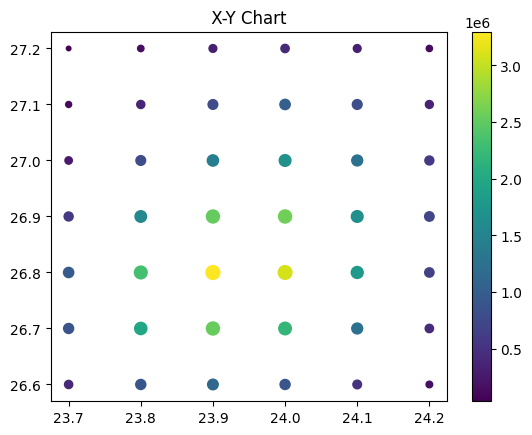

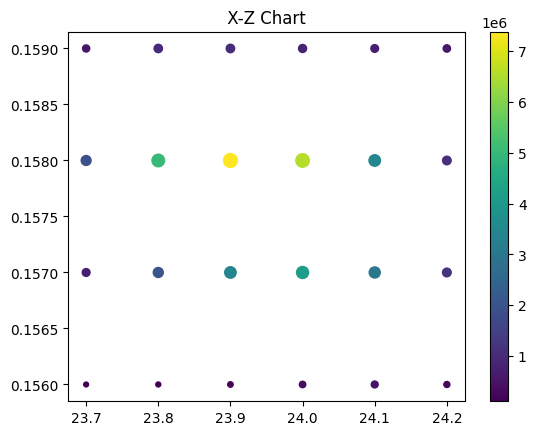

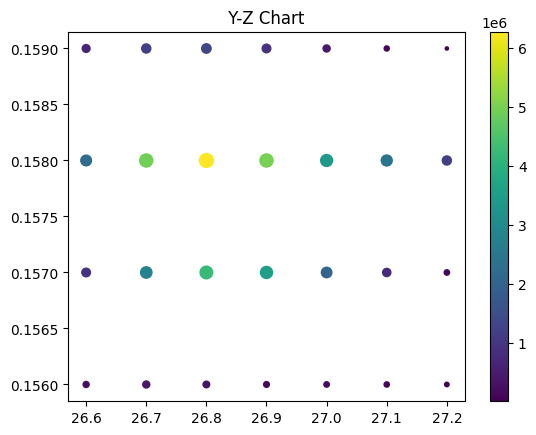

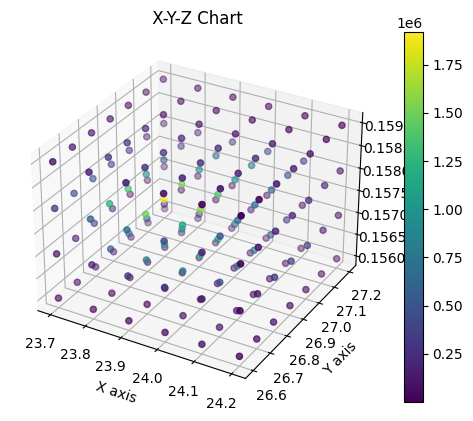

In [11]:
chart_scaling = 100
plotReadout_1(ReadoutEvt)

In [12]:
std = det.PSFstd
pitch_x = det.pitch_x
pitch_y = det.pitch_y
pitch_z = det.samplerate

# pitch_x = 1
# pitch_y = 1
# pitch_z = 1
# std = 1

thresh = 1e-10
grid_size = 50
# length = 120

DriftedEvtStack = np.stack((DriftedEvt[1], DriftedEvt[2], DriftedEvt[3]), axis=-1)
ReadoutEvt = ReadoutGain(DriftedEvtStack)
ReadoutEvt

min and max:  [23.68739767 26.58090683  0.15573763] [24.21468614 27.24884545  0.15966934]
Comma num 1 1 3
coord- 0  :  [23.8468153  26.88699592  0.15695306]
coord- 1  :  [23.96145643 27.12672226  0.1579384 ]
coord- 2  :  [24.04063923 26.77825763  0.15853934]
coord- 3  :  [23.94487946 26.82781922  0.15783758]
coord- 4  :  [23.83508719 26.77426259  0.15809275]
coord- 5  :  [24.03888907 26.95248477  0.1570074 ]
coord- 6  :  [23.99505384 26.75731915  0.15758387]
coord- 7  :  [23.89089592 26.90427182  0.15800572]
coord- 8  :  [24.11960221 26.74004493  0.15740372]
coord- 9  :  [24.08189239 26.96545641  0.15610055]
coord- 10  :  [23.99411202 27.02698117  0.15713363]
coord- 11  :  [23.90498621 26.9841543   0.15774536]
coord- 12  :  [23.71997262 26.807821    0.15890128]
coord- 13  :  [23.80327086 26.84514342  0.15848947]
coord- 14  :  [23.83028743 26.7976198   0.15775556]
coord- 15  :  [23.92769328 27.08985795  0.15837237]
coord- 16  :  [24.06345376 26.83223908  0.15719591]
coord- 17  :  [23.93

,x,y,dt,Nel
0,23.7,26.6,0.157,23671.786637
1,23.7,26.7,0.157,88936.040418
2,23.7,26.8,0.157,162315.364625
3,23.7,26.9,0.157,145927.956942
4,23.7,27.0,0.157,64725.297771
...,...,...,...,...
163,24.2,26.8,0.156,51957.264934
164,24.2,26.9,0.156,62599.850619
165,24.2,27.0,0.156,58590.332412
166,24.2,27.1,0.156,27417.478797


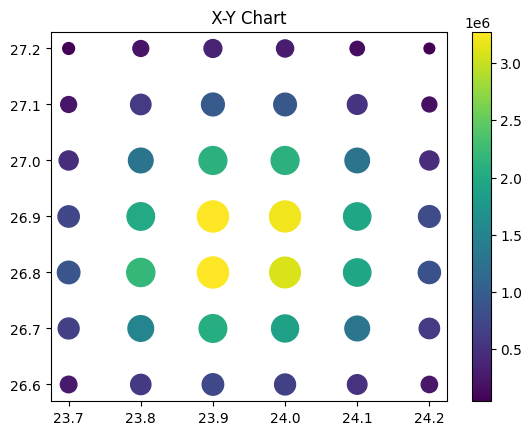

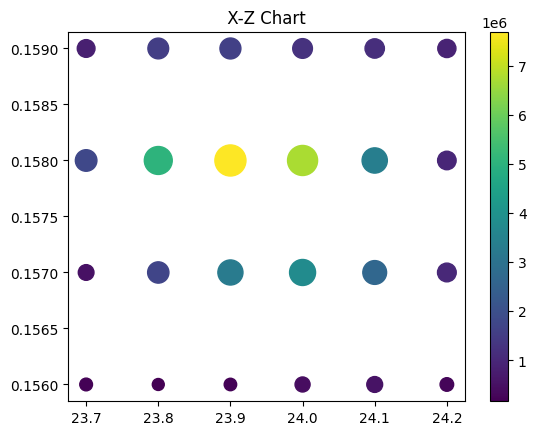

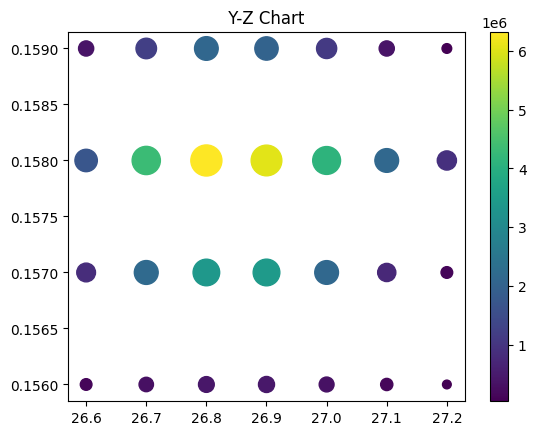

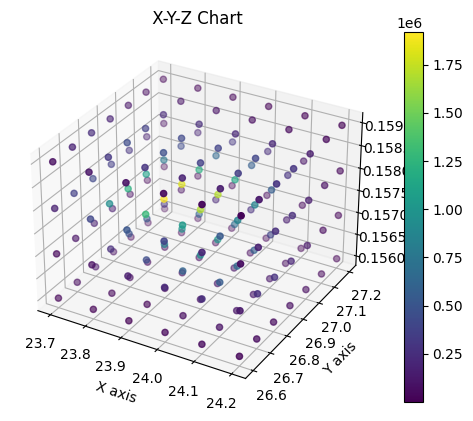

In [13]:
chart_scaling = 500
plotReadout_1(ReadoutEvt)

In [14]:
std = det.PSFstd
pitch_x = det.pitch_x
pitch_y = det.pitch_y
pitch_z = det.samplerate

# pitch_x = 1
# pitch_y = 1
# pitch_z = 1
# std = 1

thresh = 1e-10
grid_size = 50
length = 120

DriftedEvtStack = np.stack((DriftedEvt[1][:length], DriftedEvt[2][:length], DriftedEvt[3][:length]), axis=-1)
DriftedEvtStack
ReadoutEvt = ReadoutGain(DriftedEvtStack)

min and max:  [23.68739767 26.58090683  0.15573763] [24.21468614 27.24884545  0.15966934]
Comma num 1 1 3
coord- 0  :  [23.8468153  26.88699592  0.15695306]
coord- 1  :  [23.96145643 27.12672226  0.1579384 ]
coord- 2  :  [24.04063923 26.77825763  0.15853934]
coord- 3  :  [23.94487946 26.82781922  0.15783758]
coord- 4  :  [23.83508719 26.77426259  0.15809275]
coord- 5  :  [24.03888907 26.95248477  0.1570074 ]
coord- 6  :  [23.99505384 26.75731915  0.15758387]
coord- 7  :  [23.89089592 26.90427182  0.15800572]
coord- 8  :  [24.11960221 26.74004493  0.15740372]
coord- 9  :  [24.08189239 26.96545641  0.15610055]
coord- 10  :  [23.99411202 27.02698117  0.15713363]
coord- 11  :  [23.90498621 26.9841543   0.15774536]
coord- 12  :  [23.71997262 26.807821    0.15890128]
coord- 13  :  [23.80327086 26.84514342  0.15848947]
coord- 14  :  [23.83028743 26.7976198   0.15775556]
coord- 15  :  [23.92769328 27.08985795  0.15837237]
coord- 16  :  [24.06345376 26.83223908  0.15719591]
coord- 17  :  [23.93

In [15]:
ReadoutEvt

,x,y,dt,Nel
0,23.7,26.6,0.157,66300.626684
1,23.7,26.7,0.157,174381.384485
2,23.7,26.8,0.157,237074.528573
3,23.7,26.9,0.157,172524.155740
4,23.7,27.0,0.157,65722.822057
...,...,...,...,...
163,24.2,26.8,0.156,59467.313273
164,24.2,26.9,0.156,109089.753447
165,24.2,27.0,0.156,91785.561256
166,24.2,27.1,0.156,37089.054884


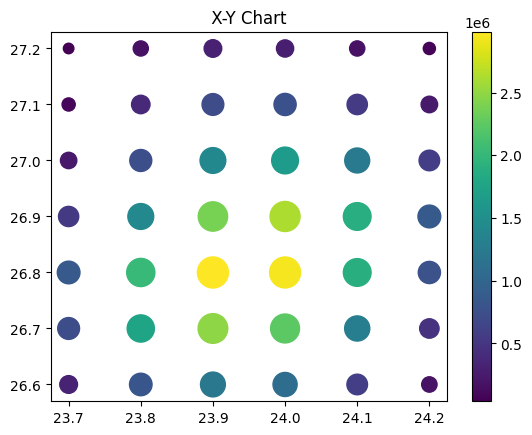

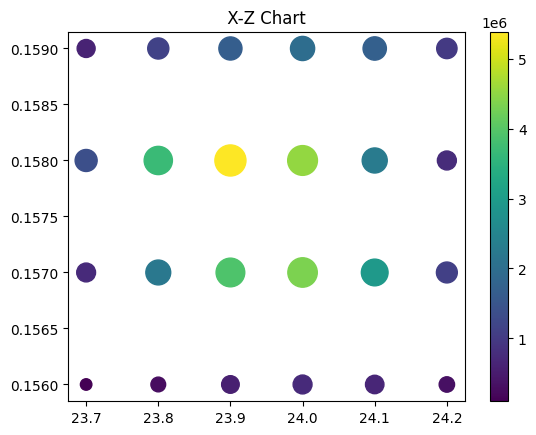

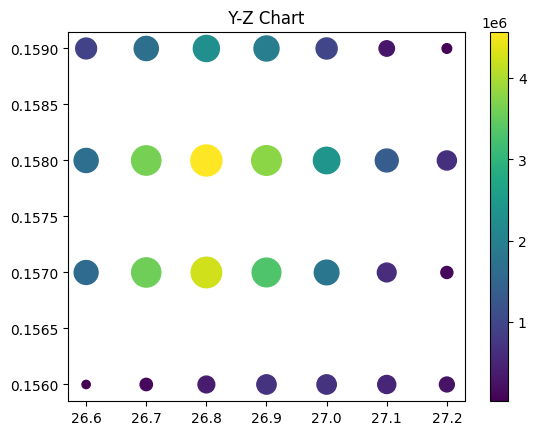

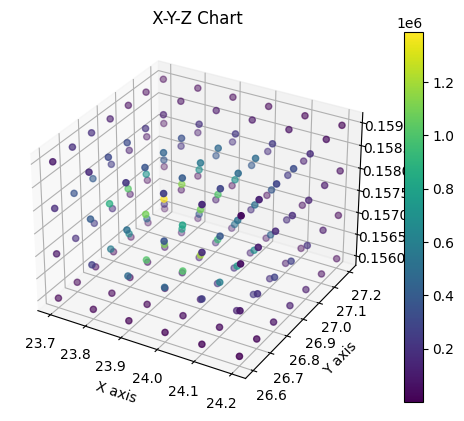

In [16]:
chart_scaling = 500
plotReadout_1(ReadoutEvt)

In [17]:
DriftedEvt = np.array([[1,1,1], [5,5,5], [10,10,10]])
ReadoutEvt = ReadoutGain(DriftedEvt)

min and max:  [1 1 1] [10 10 10]
Comma num 1 1 3
coord- 0  :  [1 1 1]
coord- 1  :  [5 5 5]
coord- 2  :  [10 10 10]


### Readout Test 1

In [18]:
ReadoutEvt = ReadoutGain(DriftedEvt)

min and max:  [1 1 1] [10 10 10]
Comma num 1 1 3
coord- 0  :  [1 1 1]
coord- 1  :  [5 5 5]
coord- 2  :  [10 10 10]


In [19]:
ReadoutEvt

,x,y,dt,Nel
0,1.0,1.0,1.0,83620.736609
1,1.0,1.1,1.0,50718.540541
2,1.0,1.2,1.0,11316.836073
3,1.0,1.3,1.0,928.942474
4,1.0,1.4,1.0,28.051632
...,...,...,...,...
336,10.0,9.6,10.0,53.245427
337,10.0,9.7,10.0,1763.246364
338,10.0,9.8,10.0,21480.738184
339,10.0,9.9,10.0,96269.989541


In [20]:
plotReadout(ReadoutEvt, -5, 30)

TypeError: plotReadout() takes 1 positional argument but 3 were given